In [51]:
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm import tqdm

import pprint
import hdbscan
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS
)

pp = pprint.PrettyPrinter(depth=4)
device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

Text  \
0  General Quality System Requirements […] Manage...   
1  General Quality System Requirements […] Manage...   
2  General Quality System Requirements […] Manage...   

                        Standard mapping?  
0  [quality management, quality planning]  
1                    [quality management]  
2                    [quality management]

In [3]:
# Reduce the dataset to contain only those regulation
# that map to a single quality topic
# Problem reduces to multi-class classification
df = df[df[TARGET].apply(lambda x: len(x)) == 1].copy()
df.reset_index(drop=True, inplace=True)

In [4]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-06 23:49:54,840 - capstone.utils.utils - INFO - func:clean took: 2.90 sec
2022-12-06 23:49:55,317 - capstone.utils.utils - INFO - func:fit took: 3.38 sec
2022-12-06 23:49:56,839 - capstone.utils.utils - INFO - func:clean took: 1.52 sec
2022-12-06 23:49:57,028 - capstone.utils.utils - INFO - func:transform took: 1.71 sec
2022-12-06 23:49:57,029 - capstone.utils.utils - INFO - func:fit_transform took: 5.09 sec
2022-12-06 23:49:57,210 - capstone.utils.utils - INFO - func:clean took: 0.18 sec
2022-12-06 23:49:57,233 - capstone.utils.utils - INFO - func:transform took: 0.20 sec
2022-12-06 23:49:57,247 - capstone.utils.utils - INFO - func:build took: 5.32 sec


Text  \
0  commencement clinical trial member state take ...   
1  production management packaging operation proc...   
2  entering agreement investigator institution co...   

                     Standard mapping?  \
0                  [clinical research]   
1  [labeling and packaging operations]   
2                  [clinical research]   

                                       Original Text  audit inspection  \
0  Commencement of a clinical trial […] Member St...                 0   
1  Production Management […] Packaging Operations...                 0   
2  Before entering an agreement with an investiga...                 0   

   calibration  change controls  clinical research  controled substances  csv  \
0            0                0                  1                     0    0   
1            0                0                  0                     0    0   
2            0                0                  1                     0    0   

   data management  ...  word__unique device  word__upon request  \
0                0  ...                  0.0                 0.0   
1                0  ...                  0.0                 0.0   
2                0  ...                  0.0                 0.0   

   word__use device  word__used manufacture  word__used production  \
0               0.0                     0.0                    0.0   
1               0.0                     0.0                    0.0   
2               0.0                     0.0                    0.0   

   word__validation process  word__way ensures  word__written procedure  \
0                       0.0                0.0                      0.0   
1                       0.0                0.0                      0.0   
2                       0.0                0.0                      0.0   

   word__year date        Split  
0              0.0  Development  
1              0.0  Development  
2              0.0  Development  

[3 rows x 532 columns]

In [5]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
Y_test = test[features.mlb.classes_].copy()

In [6]:
class JJDataset(Dataset):
  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: AutoTokenizer, 
    max_length: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_length = max_length
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    row = self.data.iloc[index]
    text = row[ORIGINAL_TEXT]
    target = row[features.mlb.classes_]

    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_token_type_ids=True,
      return_tensors='pt'
    )

    return {
        "input_ids": inputs["input_ids"].flatten(),
        "attention_mask": inputs["attention_mask"].flatten(),
        "token_type_ids": inputs["token_type_ids"].flatten(),
        "target": torch.FloatTensor(target)
    }


In [7]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(BERT_MODEL_NAME)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, len(features.mlb.classes_))

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

model = Model()
model_path = os.path.join(data.reports_path, "bert-multiclass.pth")
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval();

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# keep_topics = {
#     "audit inspection",
#     "calibration",
#     "clinical research",
#     "design controls",
#     "quality management",
#     "labeling and packaging operations",
#     "purchasing controls",
#     "documentation management",
#     "production process controls",
#     "purchasing controls",
#     "laboratory controls",
#     "vigilance"
# }

# keep_topics = {topic for topic in features.mlb.classes_}

# for topic in keep_topics:
#     assert topic in features.mlb.classes_

# def ifkeep(target, keep_topics):
#     for y in target:
#         if y not in keep_topics:
#             return False
#     return True

# e = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
# e = e[e[TARGET].apply(ifkeep, keep_topics=keep_topics)].copy()
# e.reset_index(drop=True, inplace=True)

# e.shape


# df_features[df_features[TARGET].apply(lambda x: x[0])=="qsmr"].shape
# df_features[df_features[TARGET].apply(lambda x: x[0])=="identification and traceability"].shape
# df_features[df_features[TARGET].apply(lambda x: x[0])=="csv"].shape


(19, 532)

Get embeddings

In [10]:
MAX_TOKEN_COUNT = 256
NUM_WORKERS = 0

dataset = JJDataset(
    df_features,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
dataset_loader = DataLoader(dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
embeddings = []

with torch.no_grad():
    for i, item in enumerate(dataset_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model.l1(input_ids, attention_mask, token_type_ids)
        embeddings.append(out.pooler_output.to("cpu").numpy().reshape(-1,))
        y_true.append(target.to("cpu").numpy().reshape(-1,))

y_true = np.array(y_true).argmax(axis=1)
embeddings = np.array(embeddings)

Define utility functions

In [ ]:
# Useful constants
CLUSTER = "cluster"
EMBEDDINGS = ["llm_{i}" for i in range(model.l1.config.hidden_size)]
PCA_COMP = ["pca_1", "pca_2"]
TARGET_NUMERIC = "Target Numeric"

# Utility function to compute purity scores
def compute_purity(df):
    purity_scores = {}
    purity_scores_deep = {}
    clusters_unique = df[CLUSTER].unique()
    for c in clusters_unique:
        labels = df[df[CLUSTER]==c][TARGET_NUMERIC].tolist()
        sorted_labels = sorted(list(set(labels)), key=labels.count, reverse=True)
        mode = sorted_labels[0]
        if len(sorted_labels) > 1:
            mode2 = sorted_labels[1]
        else:
            mode2 = -1
        score = sum([1 if y==mode else 0 for y in labels]) / len(labels)
        score2 = sum([1 if y==mode2 else 0 for y in labels]) / len(labels)
        mode_label = features.mlb.classes_[mode]
        mode_label2 = features.mlb.classes_[mode2] if mode2 != -1 else -1
        purity_scores[c] = (score, mode_label)
        purity_scores_deep[c] = {mode_label: score, mode_label2: score2}
    return purity_scores, purity_scores_deep

# Utility function to find quality topics that did not win any cluster
def sanity_check(scores: dict()):
    counts = {}
    for c in scores:
        if scores[c][1] not in counts:
            counts[scores[c][1]] = 1
        else:
            counts[scores[c][1]] += 1
    missing = set(features.mlb.classes_) - set([c for c in counts])
    multiple = [(c, counts[c]) for c in counts if counts[c] > 1]
    return missing, multiple

k-Means (Floyd)

In [59]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(len(features.mlb.classes_)//2, len(features.mlb.classes_)+5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.17s/it]


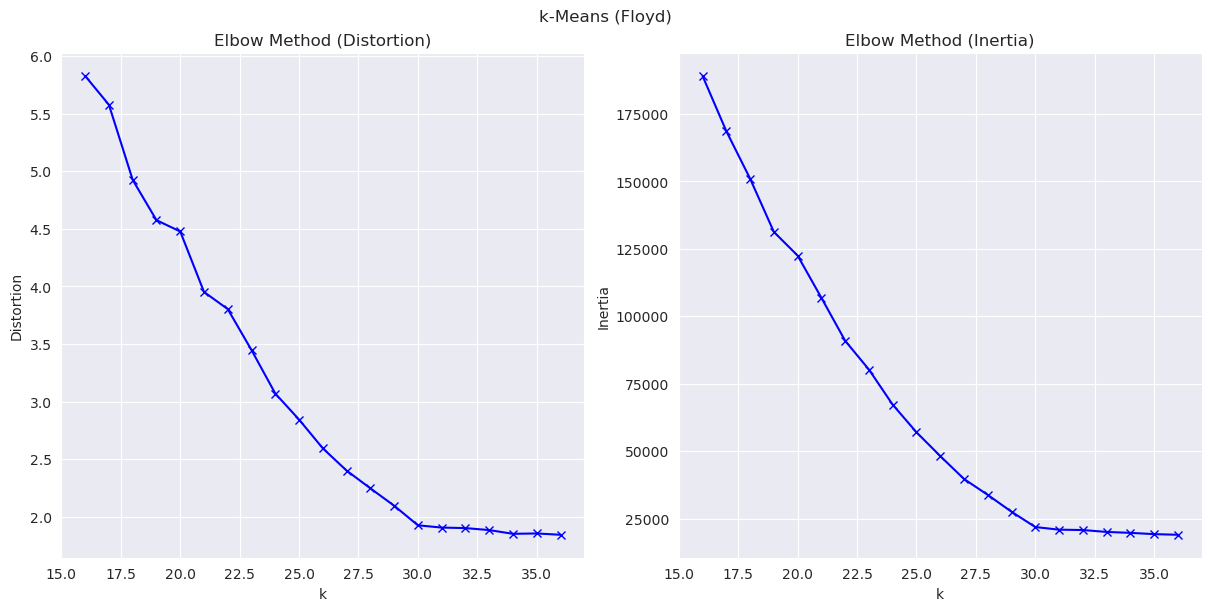

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Floyd)");

In [61]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.9733333333333334, 'labeling and packaging operations'),
 1: (0.9770992366412213, 'clinical research'),
 2: (0.979381443298969, 'production process controls'),
 3: (0.9664429530201343, 'data management'),
 4: (0.9666666666666667, 'design controls'),
 5: (0.9565217391304348, 'material and product controls'),
 6: (0.9883720930232558, 'non clinical research'),
 7: (0.9858156028368794, 'purchasing controls'),
 8: (0.9411764705882353, 'risk management'),
 9: (0.9759036144578314, 'laboratory controls'),
 10: (0.9722222222222222, 'new product quality planning'),
 11: (0.9387755102040817, 'quality management'),
 12: (0.9558823529411765, 'vigilance'),
 13: (1.0, 'laboratory controls'),
 14: (0.9710144927536232, 'udi and serialization'),
 15: (0.9746835443037974, 'documentation management'),
 16: (0.9491525423728814, 'qrb'),
 17: (1.0, 'training'),
 18: (0.9574468085106383, 'medical device post market surveillance'),
 19: (1.0, 'samd'),
 20: (0.9782608695652174, 'controled substances'),
 2

In [62]:
missing, multiple = sanity_check(scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'qsmr'}


Multiple:
[('laboratory controls', 2)]


In [63]:
pp.pprint(scores_deep)

{0: {'labeling and packaging operations': 0.9733333333333334,
     'material and product controls': 0.008888888888888889},
 1: {'clinical research': 0.9770992366412213, 'qrb': 0.007633587786259542},
 2: {'material and product controls': 0.007731958762886598,
     'production process controls': 0.979381443298969},
 3: {'data management': 0.9664429530201343,
     'documentation management': 0.013422818791946308},
 4: {'design controls': 0.9666666666666667,
     'risk management': 0.011111111111111112},
 5: {'labeling and packaging operations': 0.014492753623188406,
     'material and product controls': 0.9565217391304348},
 6: {'data management': 0.005813953488372093,
     'non clinical research': 0.9883720930232558},
 7: {'material and product controls': 0.0070921985815602835,
     'purchasing controls': 0.9858156028368794},
 8: {'labeling and packaging operations': 0.008403361344537815,
     'risk management': 0.9411764705882353},
 9: {'laboratory controls': 0.9759036144578314,
     'p

In [64]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET]
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

In [67]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



k-means (Elkan)

In [68]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(len(features.mlb.classes_)//2, len(features.mlb.classes_)+5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.24s/it]


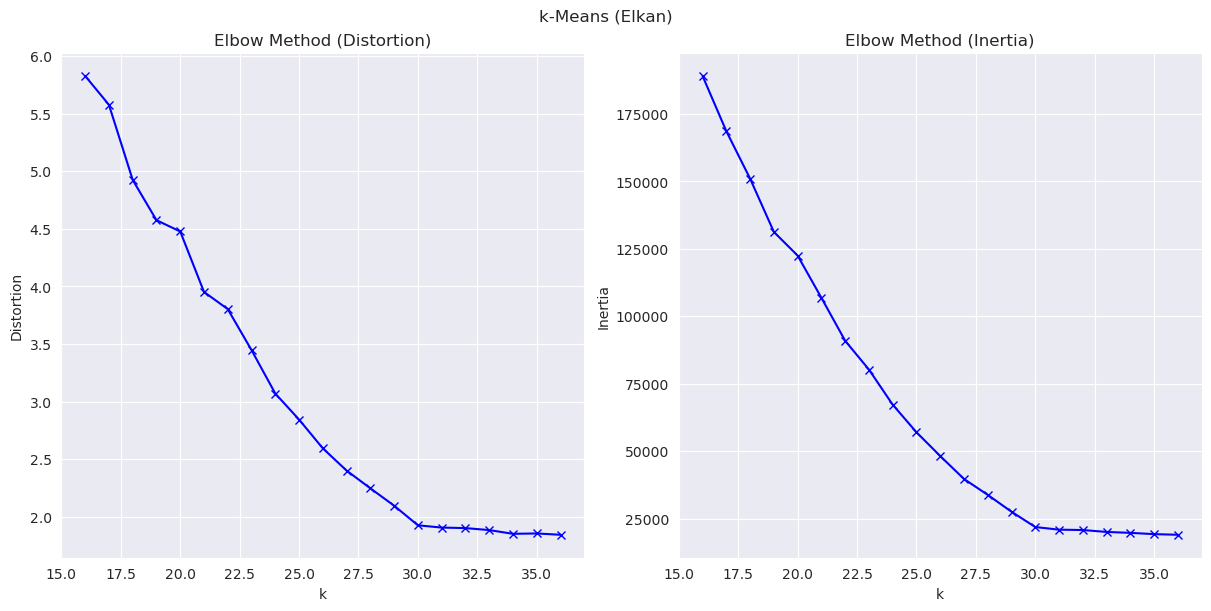

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Elkan)");

In [70]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.9733333333333334, 'labeling and packaging operations'),
 1: (0.9770992366412213, 'clinical research'),
 2: (0.979381443298969, 'production process controls'),
 3: (0.9664429530201343, 'data management'),
 4: (0.9666666666666667, 'design controls'),
 5: (0.9565217391304348, 'material and product controls'),
 6: (0.9883720930232558, 'non clinical research'),
 7: (0.9858156028368794, 'purchasing controls'),
 8: (0.9411764705882353, 'risk management'),
 9: (0.9759036144578314, 'laboratory controls'),
 10: (0.9722222222222222, 'new product quality planning'),
 11: (0.9387755102040817, 'quality management'),
 12: (0.9558823529411765, 'vigilance'),
 13: (1.0, 'laboratory controls'),
 14: (0.9710144927536232, 'udi and serialization'),
 15: (0.9746835443037974, 'documentation management'),
 16: (0.9491525423728814, 'qrb'),
 17: (1.0, 'training'),
 18: (0.9574468085106383, 'medical device post market surveillance'),
 19: (1.0, 'samd'),
 20: (0.9782608695652174, 'controled substances'),
 2

In [71]:
missing, multiple = sanity_check(scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'qsmr'}


Multiple:
[('laboratory controls', 2)]


In [72]:
pp.pprint(scores_deep)

{0: {'labeling and packaging operations': 0.9733333333333334,
     'material and product controls': 0.008888888888888889},
 1: {'clinical research': 0.9770992366412213, 'qrb': 0.007633587786259542},
 2: {'material and product controls': 0.007731958762886598,
     'production process controls': 0.979381443298969},
 3: {'data management': 0.9664429530201343,
     'documentation management': 0.013422818791946308},
 4: {'design controls': 0.9666666666666667,
     'risk management': 0.011111111111111112},
 5: {'labeling and packaging operations': 0.014492753623188406,
     'material and product controls': 0.9565217391304348},
 6: {'data management': 0.005813953488372093,
     'non clinical research': 0.9883720930232558},
 7: {'material and product controls': 0.0070921985815602835,
     'purchasing controls': 0.9858156028368794},
 8: {'labeling and packaging operations': 0.008403361344537815,
     'risk management': 0.9411764705882353},
 9: {'laboratory controls': 0.9759036144578314,
     'p

In [73]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

In [76]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
clusters = clustering_method.fit(embeddings)

dim_reduction_method = \
    umap.UMAP(
        n_neighbors=15,
        n_components=2,
        metric="cosine",
        min_dist=0.0
    )
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & UMAP"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

Hierarchical Clustering (HDBSCAN)

This algorithm figures out the number of clusters on its own

In [77]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{-1: (0.23333333333333334, 'production process controls'),
 0: (0.9722222222222222, 'new product quality planning'),
 1: (0.9655172413793104, 'qrb'),
 2: (0.9761904761904762, 'laboratory controls'),
 3: (0.9459459459459459, 'calibration'),
 4: (0.9574468085106383, 'medical device post market surveillance'),
 5: (0.9759036144578314, 'stability programs'),
 6: (0.975, 'md product cybersecurity'),
 7: (1.0, 'training'),
 8: (0.9664429530201343, 'data management'),
 9: (0.8888888888888888, 'csv'),
 10: (0.9387755102040817, 'quality management'),
 11: (0.9883720930232558, 'non clinical research'),
 12: (0.9285714285714286, 'audit inspection'),
 13: (0.9858156028368794, 'purchasing controls'),
 14: (0.9444444444444444, 'product returns'),
 15: (0.96, 'vmp'),
 16: (0.9782608695652174, 'controled substances'),
 17: (1.0, 'samd'),
 18: (0.9791666666666666, 'production process controls'),
 19: (0.9333333333333333, 'process & packaging validation'),
 20: (0.9666666666666667, 'design controls'),
 

Unclustered Samples

In [83]:
f"{sum(embeddings_df[CLUSTER] == -1) / len(embeddings_df) * 100:.3}%"

'1.08%'

In [84]:
missing, multiple = sanity_check(scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'qsmr', 'quality planning'}


Multiple:
[('production process controls', 2)]


In [85]:
pp.pprint(scores_deep)

{-1: {'production process controls': 0.23333333333333334,
      'quality planning': 0.2},
 0: {'design controls': 0.027777777777777776,
     'new product quality planning': 0.9722222222222222},
 1: {'qrb': 0.9655172413793104, 'risk management': 0.017241379310344827},
 2: {'laboratory controls': 0.9761904761904762,
     'production process controls': 0.011904761904761904},
 3: {'calibration': 0.9459459459459459,
     'non clinical research': 0.02702702702702703},
 4: {'medical device post market surveillance': 0.9574468085106383,
     'udi and serialization': 0.02127659574468085},
 5: {'laboratory controls': 0.024096385542168676,
     'stability programs': 0.9759036144578314},
 6: {'md product cybersecurity': 0.975, 'samd': 0.025},
 7: {-1: 0.0, 'training': 1.0},
 8: {'data management': 0.9664429530201343,
     'documentation management': 0.013422818791946308},
 9: {'csv': 0.8888888888888888, 'laboratory controls': 0.05555555555555555},
 10: {'quality management': 0.9387755102040817,
  

In [86]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

In [88]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

